In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms
# import torchvision.transforms.functional as F
from torch.utils.data import Subset, Dataset, DataLoader

import numpy as np
import h5py
import matplotlib.pyplot as plt
from PIL import Image
import argparse
from argparse import Namespace

import random
from tqdm import tqdm

import tensorflow as tf
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun May 16 16:00:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


# Load dataset

In [3]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, particles, counts, transform=None, seed=1234):
        self.root_dir = root_dir
        self.transform = transform
        
        self.particles = particles
        self.counts = counts

        self.labels = []
        self.data = []

        for particle in self.particles:
            for count in self.counts:
                data_dir = f'{self.root_dir}/SPI_{particle}_1k_{count}_thumbnail.h5'

                # Load images as h5 files
                f = h5py.File(data_dir, 'r')
                dset_name = list(f.keys())[0]
                data = f[dset_name]
                data = [Image.fromarray(data[i]) for i in range(LENGTH)]
                data = [self.transform(data[i]) for i in range(LENGTH)]
                # label = np.array([1 if i==self.counts.index(count) else 0 for i in range(len(self.counts))])
                # label = np.array([label for _ in range(LENGTH)])
                label = [self.counts.index(count)] * LENGTH
                self.data.extend(data)
                self.labels.extend(label)
        
        # Shuffle the data
        random.seed(seed)
        perm = list(range(len(self.data)))
        random.shuffle(perm)
        self.data = [self.data[i] for i in perm]
        self.labels = [self.labels[i] for i in perm]

    def __len__(self):
        '''Denotes the total number of samples'''
        return len(self.data)

    def __getitem__(self, index):
        '''Generates one sample of data'''
        X = self.data[index]
        y = self.labels[index]
        return X, y

In [4]:
def get_dataloaders(args, train_val_particles, test_particles, test_diff_particle=False):
    transform = transforms.Compose([transforms.CenterCrop(128),
                                    transforms.ToTensor()])
    
    if not test_diff_particle:
        assert train_val_particles == test_particles
        dataset = CustomDataset(root_dir=args.root_dir,
                                particles=train_val_particles,
                                counts=COUNTS,
                                transform=transform)
        train_idx = list(range(0, 7000))
        valid_idx = list(range(7000, 8000))
        test_idx = list(range(8000, 9000))
        train_dataset = Subset(dataset, train_idx) 
        valid_dataset = Subset(dataset, valid_idx)
        test_dataset = Subset(dataset, test_idx)
    else:
        # Create train/valid/test datasets
        train_val_dataset = CustomDataset(root_dir=args.root_dir, 
                                          particles=train_val_particles,
                                          counts=COUNTS,
                                          transform=transform)
        train_idx = list(range(0, 7000))
        valid_idx = list(range(7000, 8000))
        train_dataset = Subset(train_val_dataset, train_idx) 
        valid_dataset = Subset(train_val_dataset, valid_idx)
        test_dataset = CustomDataset(root_dir=args.root_dir, 
                                    particles=test_particles,
                                    counts=COUNTS,
                                    transform=transform)
        
        assert train_dataset.__getitem__(0)[0].shape == torch.Size([1, 128, 128])
        assert valid_dataset.__getitem__(0)[0].shape == torch.Size([1, 128, 128])
        assert test_dataset.__getitem__(0)[0].shape == torch.Size([1, 128, 128])

    # Create train/valid/test dataloaders
    train_dataloader = DataLoader(dataset=train_dataset,
                                  batch_size=args.batch_size,
                                  shuffle=args.shuffle, 
                                  num_workers=args.num_workers)
    valid_dataloader = DataLoader(dataset=valid_dataset,
                                  batch_size=args.batch_size,
                                  shuffle=args.shuffle, 
                                  num_workers=args.num_workers)
    test_dataloader = DataLoader(dataset=test_dataset, 
                                 batch_size=args.batch_size, 
                                 shuffle=args.shuffle, 
                                 num_workers=args.num_workers)
    return train_dataloader, valid_dataloader, test_dataloader

# Models

## 3-layer MLP

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
                
        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)
        
    def forward(self, x):
        
        #x = [batch size, height, width]
        
        batch_size = x.shape[0]

        x = x.view(batch_size, -1)
        
        #x = [batch size, height * width]
        
        h_1 = F.relu(self.input_fc(x))
        
        #h_1 = [batch size, 250]

        h_2 = F.relu(self.hidden_fc(h_1))

        #h_2 = [batch size, 100]

        y_pred = self.output_fc(h_2)
        
        #y_pred = [batch size, output dim]
        
        return y_pred

In [ ]:
INPUT_DIM = 128 * 128
OUTPUT_DIM = 3
mlp = MLP(INPUT_DIM, OUTPUT_DIM).to(device)

In [ ]:
summary(mlp, input_size=(1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 250]       4,096,250
            Linear-2                  [-1, 100]          25,100
            Linear-3                    [-1, 3]             303
Total params: 4,121,653
Trainable params: 4,121,653
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 0.00
Params size (MB): 15.72
Estimated Total Size (MB): 15.79
----------------------------------------------------------------


## ResNet18

In [ ]:
resnet18 = models.resnet18(pretrained=False)
resnet18.conv1 = torch.nn.Conv1d(1, 64, (7, 7), (2, 2), (3, 3), bias=False)

# Add drop-out layer to the resnet
# resnet18.fc.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.5, training=m.training))

In [ ]:
summary(resnet18.to(device), input_size=(1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1           [-1, 64, 64, 64]           3,136
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

## CNN

In [30]:
class CNN(nn.Module):
    def __init__(self, num_classes=3, hidden_dim=8):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, hidden_dim, 2, 2)
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim * 2, 2, 2)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(16384, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        # x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [31]:
num_classes = 3
hidden_dim = 8

cnn = CNN(num_classes, hidden_dim)

In [32]:
summary(cnn.to(device), input_size=(1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 64, 64]              40
            Conv2d-2           [-1, 16, 32, 32]             528
           Dropout-3           [-1, 16, 32, 32]               0
            Linear-4                  [-1, 128]       2,097,280
           Dropout-5                  [-1, 128]               0
            Linear-6                    [-1, 3]             387
Total params: 2,098,235
Trainable params: 2,098,235
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 0.50
Params size (MB): 8.00
Estimated Total Size (MB): 8.57
----------------------------------------------------------------


## VGG11

In [14]:
vgg11 = models.vgg11(pretrained=False)
vgg11.features[0] = torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [7]:
summary(vgg11.to(device), input_size=(1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]             640
              ReLU-2         [-1, 64, 128, 128]               0
         MaxPool2d-3           [-1, 64, 64, 64]               0
            Conv2d-4          [-1, 128, 64, 64]          73,856
              ReLU-5          [-1, 128, 64, 64]               0
         MaxPool2d-6          [-1, 128, 32, 32]               0
            Conv2d-7          [-1, 256, 32, 32]         295,168
              ReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 256, 32, 32]         590,080
             ReLU-10          [-1, 256, 32, 32]               0
        MaxPool2d-11          [-1, 256, 16, 16]               0
           Conv2d-12          [-1, 512, 16, 16]       1,180,160
             ReLU-13          [-1, 512, 16, 16]               0
           Conv2d-14          [-1, 512,

## VGG16

In [15]:
vgg16 = models.vgg16(pretrained=False)
vgg16.features[0] = torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [ ]:
summary(vgg16.to(device), input_size=(1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]             640
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14          [-1, 256,

## AlexNet

In [ ]:
alexnet = models.alexnet(pretrained=False)
alexnet.features[0] = torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [ ]:
summary(alexnet.to(device), input_size=(1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]             640
              ReLU-2         [-1, 64, 128, 128]               0
         MaxPool2d-3           [-1, 64, 63, 63]               0
            Conv2d-4          [-1, 192, 63, 63]         307,392
              ReLU-5          [-1, 192, 63, 63]               0
         MaxPool2d-6          [-1, 192, 31, 31]               0
            Conv2d-7          [-1, 384, 31, 31]         663,936
              ReLU-8          [-1, 384, 31, 31]               0
            Conv2d-9          [-1, 256, 31, 31]         884,992
             ReLU-10          [-1, 256, 31, 31]               0
           Conv2d-11          [-1, 256, 31, 31]         590,080
             ReLU-12          [-1, 256, 31, 31]               0
        MaxPool2d-13          [-1, 256, 15, 15]               0
AdaptiveAvgPool2d-14            [-1, 25

## 18-layer CNN

# Logger (tensorboard)

In [ ]:
import tensorflow as tf
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter

class Logger(object):
    def __init__(self, log_dir):
        """Create a summary writer logging to log_dir."""
        self.writer = tf.summary.create_file_writer(log_dir)

    def scalar_summary(self, tag, value, step):
        """Log a scalar variable."""
        with self.writer.as_default():
            tf.summary.scalar(tag, value, step=step)
            self.writer.flush()

    def list_of_scalars_summary(self, tag_value_pairs, step):
        """Log scalar variables."""
        with self.writer.as_default():
            for tag, value in tag_value_pairs:
                tf.summary.scalar(tag, value, step=step)
            self.writer.flush()

# Evalutate

In [33]:
def evaluate(model, loss_fn, dataloader):
    """Evaluate the model on `num_steps` batches.
    Args:
        model: (torch.nn.Module) the neural network
        loss_fn: a function that takes batch_output and batch_labels and computes the loss for the batch
        dataloader: (DataLoader) a torch.utils.data.DataLoader object that fetches data
    """
    model.eval()

    accuracies = []
    loss = 0.0

    for i, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        preds = model(images)
        loss += loss_fn(preds, labels.to(device))
        
        preds = torch.argmax(preds, dim=-1)
        assert preds.shape == labels.shape
        correct_pred = [1 if preds[i] == labels[i] else 0 for i in range(preds.shape[0])]
        acc = sum(correct_pred) / len(preds)

        accuracies.append(acc)

        # torch.cuda.empty_cache()
        
    loss = loss / len(dataloader)
    accuracy = np.mean(accuracies)

    return accuracy, loss

In [34]:
"""
Define evaluation metric

We will use accuracy as an evaluation metric
"""

def calculate_accuracy(loader):
    total = 0
    correct = 0
  
    all_images = []
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = model(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.squeeze().to(device)).sum().item()
            
            all_images.append(images)
            all_preds.append(predicted.cpu().data.numpy())
            all_labels.append(labels)

    return 100 * correct / total, all_images, all_preds, all_labels

# Train

In [35]:
def train(args, model, optimizer, loss_fn):
    """""
    Train the network on the training data
    """
    # writer = SummaryWriter(args.logdir)

    EPOCH = args.epoches

    train_dataloader, valid_dataloader, test_dataloader = get_dataloaders(args, 
                                                                          PARTICLES, 
                                                                          PARTICLES,
                                                                          test_diff_particle=False)

    step = 0

    train_loss_values = []
    # valid_loss_values = []
    for epoch in range(EPOCH):
        epoch_train_loss = 0.0
        with tqdm(total=len(train_dataloader)) as t: 
            for i, (inputs, labels) in enumerate(train_dataloader):
                step += 1
                model.train()

                inputs = inputs.to(device)
                
                outputs = model(inputs)
                loss = loss_fn(outputs, labels.squeeze(0).to(device))
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                cost = loss.item()
                
                epoch_train_loss = cost
                
                t.set_postfix(train_loss='{:05.3f}'.format(cost))
                t.update()
                
                # torch.cuda.empty_cache()
        
        if epoch % args.evaluate_every == 0:
            accuracy, valid_loss = evaluate(model, criterion, valid_dataloader)
            # epoch_valid_loss = valid_loss
            # writer.add_scalar("valid/loss", loss, step)
            # writer.add_scalar("valid/accuracy", accuracy, step)
            # writer.add_scalar("train/loss", cost, step)
            print(f'Step {step}: valid loss={valid_loss}, valid accuracy={accuracy}')

        train_loss_values.append(epoch_train_loss)
        # valid_loss_values.append(epoch_valid_loss)

    torch.save(model.state_dict(), args.save_path) 

    """
    Plot the epoch loss
    """
    plt.figure(figsize=(10,5))
    # plt.title("Training and Validation Loss")
    plt.title("Training Loss")
    # plt.plot(valid_loss_values,label="val", color='r')
    plt.plot(train_loss_values,label="train", color='b')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    """
    Report results on the train and test data (using the evaluation metric)
    """
    
    train_accuracy, _ , _, _ = calculate_accuracy(train_dataloader)
    test_accuracy, images, preds, labels = calculate_accuracy(test_dataloader)

    print('Train accuracy: %f' % train_accuracy)
    print('Test accuracy: %f' % test_accuracy)

    images = np.concatenate(images, axis=0)
    preds = np.concatenate(preds, axis=0)
    labels = np.squeeze(np.concatenate(labels, axis=0))

    return images, preds, labels

# Run the pipeline

In [36]:
PARTICLES = ['1fpv', '1ss8', '3j03']
COUNTS = ['single', 'double', 'triple'] # 'quadruple']
LENGTH = 1000

In [43]:
args = {
    'model': 'cnn', # mlp || resnet18 || vgg16 || alexnet
    'root_dir': '/content/drive/Shareddrives/CS230/Simulated/thumbnail',
    'epoches': 20,
    'batch_size': 128,
    'shuffle': False,
    'num_workers': 1,
    'evaluate_every': 1,
    'logdir': '/content/drive/Shareddrives/CS230/logs'
}
args = Namespace(**args)
args.save_path = f'/content/drive/Shareddrives/CS230/{args.model}_checkpoint.pth'

In [44]:
"""
Define loss function and optimizer

We will use the cross entropy loss and Adam optimizer
"""

# Create model
if args.model == 'mlp':
    model = mlp.to(device)
elif args.model == 'vgg16':
    model = vgg16.to(device)
elif args.model == 'resnet18':
    model = resnet18.to(device)
elif args.model == 'alexnet':
    model = alexnet.to(device)
elif args.model == 'cnn':
    model = cnn.to(device)


# Define the cost function
criterion = nn.CrossEntropyLoss()

# Define the optimizer, learning rate 
optimizer = optim.Adam(model.parameters(), lr=0.001)

  0%|          | 0/55 [00:00<?, ?it/s]

Step 55: valid loss=0.14512589573860168, valid accuracy=0.9624399038461539


  0%|          | 0/55 [00:00<?, ?it/s]

Step 110: valid loss=0.1551811248064041, valid accuracy=0.9492938701923077


  0%|          | 0/55 [00:00<?, ?it/s]

Step 165: valid loss=0.10522302240133286, valid accuracy=0.9607121394230769


  0%|          | 0/55 [00:00<?, ?it/s]

Step 220: valid loss=0.1007363572716713, valid accuracy=0.9607121394230769


  0%|          | 0/55 [00:00<?, ?it/s]

Step 275: valid loss=0.1102733314037323, valid accuracy=0.9775390625


  0%|          | 0/55 [00:00<?, ?it/s]

Step 330: valid loss=0.10063593089580536, valid accuracy=0.9775390625


  0%|          | 0/55 [00:00<?, ?it/s]

Step 385: valid loss=0.09782693535089493, valid accuracy=0.9880558894230769


  0%|          | 0/55 [00:00<?, ?it/s]

Step 440: valid loss=0.07567614316940308, valid accuracy=0.9907602163461539


  0%|          | 0/55 [00:00<?, ?it/s]

Step 495: valid loss=0.11661991477012634, valid accuracy=0.9788161057692308


  0%|          | 0/55 [00:00<?, ?it/s]

Step 550: valid loss=0.09353296458721161, valid accuracy=0.9880558894230769


  0%|          | 0/55 [00:00<?, ?it/s]

Step 605: valid loss=0.09048958867788315, valid accuracy=0.9792668269230769


  0%|          | 0/55 [00:00<?, ?it/s]

Step 660: valid loss=0.06702379882335663, valid accuracy=0.9821965144230769


  0%|          | 0/55 [00:00<?, ?it/s]

Step 715: valid loss=0.0631227195262909, valid accuracy=0.9912109375


  0%|          | 0/55 [00:00<?, ?it/s]

Step 770: valid loss=0.09234842658042908, valid accuracy=0.9831730769230769


  0%|          | 0/55 [00:00<?, ?it/s]

Step 825: valid loss=0.05171146243810654, valid accuracy=0.9931640625


  0%|          | 0/55 [00:00<?, ?it/s]

Step 880: valid loss=0.055590178817510605, valid accuracy=0.9833984375


  0%|          | 0/55 [00:00<?, ?it/s]

Step 935: valid loss=0.06436123698949814, valid accuracy=0.9873046875


  0%|          | 0/55 [00:00<?, ?it/s]

Step 990: valid loss=0.05257469788193703, valid accuracy=0.9912109375


  0%|          | 0/55 [00:00<?, ?it/s]

Step 1045: valid loss=0.06027824804186821, valid accuracy=0.986328125


100%|██████████| 55/55 [00:00<00:00, 71.28it/s, train_loss=0.131]


Step 1100: valid loss=0.06436005234718323, valid accuracy=0.9873046875


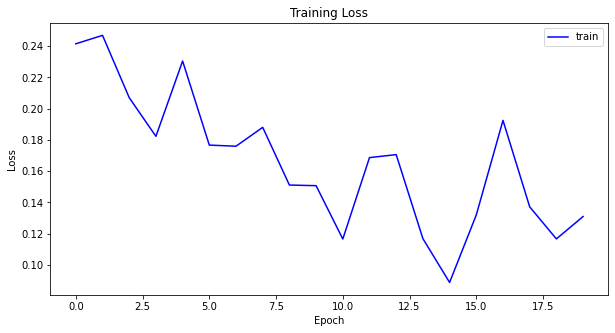

Train accuracy: 99.257143
Test accuracy: 98.400000


In [45]:
images, preds, labels = train(args, model, optimizer, criterion)

# Error analysis

In [ ]:
import tensorboard
import tensorflow as tf
%load_ext tensorboard

In [ ]:
tf.__version__

'2.4.1'

In [ ]:
tensorboard.__version__

'2.4.1'

In [ ]:
%cd /content/drive/Shareddrives/CS230/
%ls

/content/drive/Shareddrives/CS230
 checkpoints/
'experiment record'/
 logs/
 notebooks/
 resnet18_checkpoint.pth
 resnet_checkpoint
"Shawn's workspace"/
 Simulated/
'X-ray crystallography particle images classification.gslides'


In [ ]:
%tensorboard --logdir_spec 1:./logs --bind_all

In [ ]:
! tensorboard --logdir=d:/data --host 0.0.0.0

2021-05-15 23:38:42.904753: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
TensorBoard 2.4.1 at http://0.0.0.0:6006/ (Press CTRL+C to quit)


In [ ]:
##### VIEW PREDICTIONS #####
import matplotlib.pyplot as plt
import numpy as np


def unison_shuffled_copies(a, b, c):
    assert len(a) == len(b) == len(c)
    p = np.random.permutation(len(a))
    return a[p], b[p], c[p]

images, labels, preds = unison_shuffled_copies(images, labels, preds)

fig, axs = plt.subplots(5, 5, figsize=(10, 10))
flatted_axs = [item for one_ax in axs for item in one_ax]
for ax, img, label, pred in zip(flatted_axs, images[:25], labels[:25], preds[:25]):
    ax.imshow(np.reshape(img, (128, 128)))
    ax.set_title('l:{},p:{}'.format(label, pred))
    ax.axis('off')
plt.show()  